# Check training

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
root_path = os.path.abspath("..")
if root_path not in sys.path:
    sys.path.append(root_path)
    
os.environ['PRETRAINED_MODELS'] = '../../../pretrained-models.pytorch/'
os.environ['IGNITE_PATH'] = '../../../pytorch-ignite-master/'
ignite_path = os.environ['IGNITE_PATH']
if ignite_path not in sys.path:
    sys.path.append(ignite_path)

In [4]:
CONFIG = {
  "seed": 7777,

  "n_epochs": 200,
  "validate_every_epoch": 4,

  "fold_index": [0, 1, 2, 3, 4, 5, 6],
  "n_splits": 7,

  "batch_size": 32,
  "num_workers": 12,

  "lr_schedulers": [
      {"ExponentialLR": {"gamma": 0.88 } },
      {"ReduceLROnPlateau": {"factor": 0.2, "mode": "max",  "patience": 5, "verbose": "True"}}
  ],
  "early_stopping": {"patience": 10, "mode": "max"},

  "train_aug": {
    "Compose": {
      "transforms": [
        {"RandomApply": {"proba": 0.9, 
            "transforms": [
                {"RandomAffine": {
                      "translate": [0.15, 0.15],
                      "rotation": [-90, 90],
                      "interpolation": 0}},
                {"RandomFlip": {"mode": "h", "proba": 0.75}}, 
                {"RandomFlip": {"mode": "v", "proba": 0.75}} 
            ]}
        },
        { "_ToTensor": {}}
    ]}
  },

  "test_aug": {
    "Compose": {
      "transforms": [
        {"RandomAffine": {"translate": [0.15, 0.15], 
                            "rotation": [-2, 2],                                             
                            "interpolation": 0}},        
        {"RandomFlip": {"mode": "h", "proba": 0.75}},
        {"RandomFlip": {"mode": "v", "proba": 0.75}},
        {"_ToTensor": {}},
      ]
    }
  },

  "optimizer": {
    "Adam": {
      "params": [{
        "params": {
          "model.features.parameters": {}},
          "lr": 0.001}, {
        "params": {
          "model.classifier.parameters": {}},
          "lr": 0.001}]}
  }
}

## Setup dataflow

In [5]:
from common.dataflow import get_trainval_batches

In [6]:
train_batches, val_batches = get_trainval_batches(CONFIG['train_aug'], 
                                                  CONFIG['test_aug'], 
                                                  n_splits=CONFIG['n_splits'], 
                                                  fold_index=CONFIG['fold_index'], 
                                                  batch_size=CONFIG['batch_size'], 
                                                  num_workers=CONFIG['num_workers'], 
                                                  seed=CONFIG['seed'])

train_aug:  [<common.torch_common_utils.imgaug.RandomApply object at 0x7f15c2b2e2b0>, <common.dataflow._ToTensor object at 0x7f15c2b2e5c0>]
val_aug:  [<common.torch_common_utils.imgaug.RandomAffine object at 0x7f15c74de160>, <common.torch_common_utils.imgaug.RandomFlip object at 0x7f15c2b2e320>, <common.torch_common_utils.imgaug.RandomFlip object at 0x7f15c2b2e438>, <common.dataflow._ToTensor object at 0x7f15c2b2e390>]


Check dataflow

In [7]:
for batch_x, batch_y in train_batches:
    break
print(type(batch_x), type(batch_y))
for b in batch_x:
    print(type(b), b.size())

<class 'list'> <class 'torch.cuda.LongTensor'>
<class 'torch.cuda.FloatTensor'> torch.Size([32, 2, 75, 75])
<class 'torch.cuda.DoubleTensor'> torch.Size([32])


In [8]:
batch_y[:10]


 1
 0
 0
 1
 0
 0
 0
 0
 1
 0
[torch.cuda.LongTensor of size 10 (GPU 0)]

In [9]:
import matplotlib.pylab as plt
%matplotlib inline

from common.dataflow_visu_utils import display_batches

train_aug:  [<common.torch_common_utils.imgaug.RandomApply object at 0x7f16254699b0>, <common.dataflow._ToTensor object at 0x7f1625469a20>]
val_aug:  [<common.torch_common_utils.imgaug.RandomAffine object at 0x7f1625469b00>, <common.torch_common_utils.imgaug.RandomFlip object at 0x7f16254698d0>, <common.torch_common_utils.imgaug.RandomFlip object at 0x7f1625469898>, <common.dataflow._ToTensor object at 0x7f16254695f8>]
- Epoch : 1 / 3
- Epoch : 2 / 3
- Epoch : 3 / 3


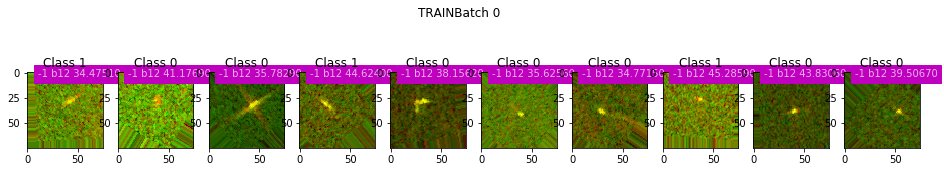

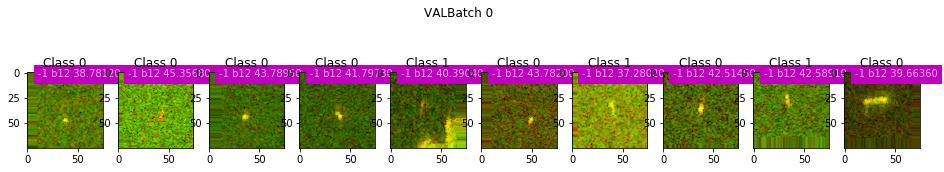

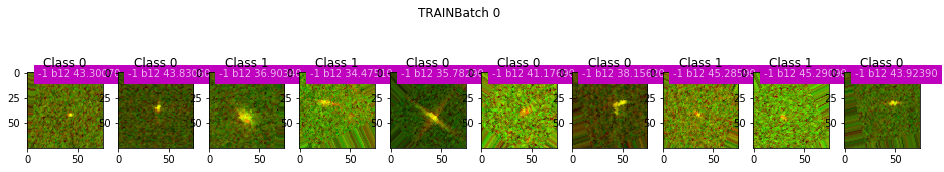

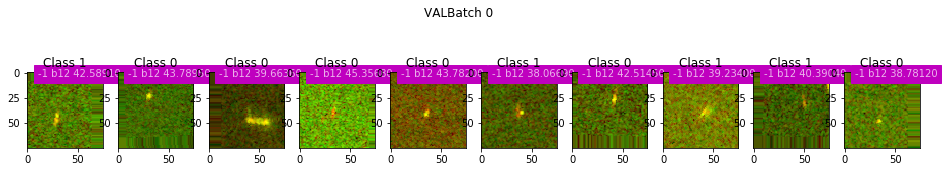

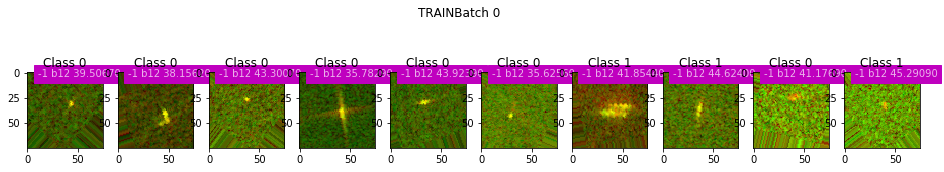

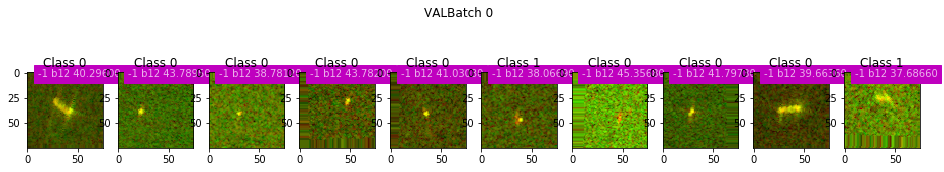

In [10]:
train_batches, val_batches = get_trainval_batches(CONFIG['train_aug'], 
                                                  CONFIG['test_aug'], 
                                                  n_splits=2, 
                                                  fold_index=CONFIG['fold_index'], 
                                                  batch_size=10, 
                                                  num_workers=CONFIG['num_workers'], 
                                                  seed=CONFIG['seed'], 
                                                  limit_n_samples=30)

for i in range(3):

    print("- Epoch : %i / %i" % (i + 1, 3))
    display_batches(train_batches, max_batches=3, n_cols=10, suptitle_prefix='TRAIN', figsize=(16, 3))
    display_batches(val_batches, max_batches=3, n_cols=10, suptitle_prefix='VAL', figsize=(16, 3))

## Setup model, loss function and optimizer

In [11]:
from common.torch_common_utils.nn_utils import print_trainable_parameters

In [12]:
from common.models import IcebergSqueezeNet
model = IcebergSqueezeNet(input_n_channels=1).cuda()
# print_trainable_parameters(model)

Check model

In [13]:
import torch
from torch.autograd import Variable

In [14]:
x = Variable(torch.randn((5, 2, 75, 75)).cuda())
y_pred = model(x, None)
type(y_pred), y_pred.size()

(torch.autograd.variable.Variable, torch.Size([5, 2]))

In [16]:
from common.torch_common_utils.training_utils import apply_variable

In [18]:
for batch_x, batch_y in train_batches:
    batch_x = apply_variable(batch_x, requires_grad=True)
    batch_y = apply_variable(batch_y, requires_grad=True)    
    y_pred = model(*batch_x)
    break
type(y_pred), y_pred.size()

(torch.autograd.variable.Variable, torch.Size([10, 2]))

Define loss function

In [19]:
from torch.nn import CrossEntropyLoss, BCELoss
from torch.nn.functional import softmax, binary_cross_entropy
criterion = CrossEntropyLoss().cuda()

In [20]:
import numpy as np


def np_logloss(y_true, y_pred):
    return -np.mean((y_true * np.log(y_pred) + (1 - y_true) * np.log(1.0 - y_pred)))

In [21]:
# single value check
y_true = 1  # is iceberg
y_pred = 0.75 # proba is iceberg

np_logloss(y_true, y_pred)

0.2876820724517809

In [22]:
# batch check
y_true = np.array([1, 0, 1, 0, 1, 0])  # is iceberg
y_pred = np.array([0.75, 0.2, 0.88, 0.05, 0.6, 0.15]) # proba is iceberg

np_logloss(y_true, y_pred)

0.22721614048786529

In [23]:
def logloss_metric(y_pred, y_true):
    """
    Compute -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))    
    yt = batch of [integer 0 or 1]
    yp = batch of [float between [0, 1]]
    """
    if y_true.type() != y_pred.type():
        y_true = y_true.type_as(y_pred)    
    return binary_cross_entropy(y_pred, y_true)

In [24]:
import torch

In [25]:
y_true = torch.from_numpy(np.array([1, 0, 1, 0, 1, 0]))  # is iceberg
y_pred = torch.from_numpy(np.array([0.75, 0.2, 0.88, 0.05, 0.6, 0.15])) # proba is iceberg

In [26]:
logloss_metric(y_pred, y_true)

Variable containing:
 0.2272
[torch.DoubleTensor of size 1]

In [27]:
from common.torch_common_utils.training_utils import accuracy


def accuracy_logits(y_logits, y_true):
    y_pred = softmax(y_logits).data
    return accuracy(y_pred, y_true)


def logloss_logits(y_logits, y_true):
    """
    Compute -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
    
    yt = integer 0 or 1
    yp = float between [0, 1]    
    """
    y_pred = softmax(y_logits)    
    y_probas = y_pred[:, 1].data    
    if isinstance(y_probas, Variable):
        y_probas = y_probas.data
    if isinstance(y_true, Variable):
        y_true = y_true.data
    if y_true.type() != y_probas.type():
        y_true = y_true.type_as(y_probas)     
    return binary_cross_entropy(y_probas, y_true).data.cpu().numpy()[0]

In [29]:
for batch_x, batch_y in train_batches:
    batch_x = apply_variable(batch_x, requires_grad=True)
    batch_y = apply_variable(batch_y, requires_grad=False)
    y_logits = model(*batch_x)
    print(type(y_logits.data), y_logits.size(), type(batch_y.data), batch_y.size())
    loss = criterion(y_logits.data, batch_y)
    print("Loss : ", loss)    
    train_acc = accuracy_logits(y_logits, batch_y)
    print("Acc: ", train_acc)
    train_logloss_val = logloss_logits(y_logits, batch_y)
    print("LogLoss: ", train_logloss_val)
    break

<class 'torch.cuda.FloatTensor'> torch.Size([10, 2]) <class 'torch.cuda.LongTensor'> torch.Size([10])
Loss :  Variable containing:
 0.7212
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Acc:  0.5
LogLoss:  0.721221


In [30]:
y_pred = softmax(y_logits)

In [31]:
y_probas = y_pred[:, 1]
y_probas[:10]

Variable containing:
 0.6099
 0.5822
 0.5971
 0.5772
 0.5859
 0.5907
 0.5974
 0.5964
 0.6051
 0.5931
[torch.cuda.FloatTensor of size 10 (GPU 0)]

In [32]:
y_pred = y_pred.data.cpu().numpy()
batch_y = batch_y.data.cpu().numpy()

for pred, target in zip(y_pred, batch_y):
    print(pred, "<->", target)

[ 0.39006212  0.60993791] <-> 0
[ 0.41775498  0.58224505] <-> 0
[ 0.40291047  0.59708953] <-> 0
[ 0.42280036  0.57719958] <-> 1
[ 0.41405752  0.58594251] <-> 1
[ 0.4092876   0.59071243] <-> 1
[ 0.40260777  0.59739226] <-> 0
[ 0.40362999  0.59637004] <-> 1
[ 0.39487025  0.60512978] <-> 0
[ 0.40693268  0.59306729] <-> 1


Setup optimizer

In [33]:
from common.torch_common_utils.deserialization import restore_object, CustomObjectEval

In [34]:
CONFIG['optimizer'] 

{'Adam': {'params': [{'lr': 0.001,
    'params': {'model.features.parameters': {}}},
   {'lr': 0.001, 'params': {'model.classifier.parameters': {}}}]}}

In [35]:
custom_objects = CustomObjectEval(globals=globals())
optimizer = restore_object(CONFIG['optimizer'], custom_objects=custom_objects, verbose_debug=False)

Setup learning rate scheduler

In [36]:
CONFIG['lr_schedulers']

[{'ExponentialLR': {'gamma': 0.88}},
 {'ReduceLROnPlateau': {'factor': 0.2,
   'mode': 'max',
   'patience': 5,
   'verbose': 'True'}}]

In [37]:
params_to_insert = {'optimizer': '_opt' }
custom_objects = {"_opt": optimizer}

lr_schedulers_conf = CONFIG['lr_schedulers']

lr_schedulers = []
if not isinstance(lr_schedulers_conf, (tuple, list)):
    lr_schedulers_conf = [lr_schedulers_conf]
    
for s in lr_schedulers_conf:
    scheduler = restore_object(s, params_to_insert=params_to_insert, custom_objects=custom_objects, verbose_debug=False)
    lr_schedulers.append(scheduler)

In [38]:
lr_schedulers

In [39]:
from common.torch_common_utils.training_utils import optimizer_to_str

In [40]:
print(optimizer_to_str(optimizer))
lr_schedulers[0].step()
print(optimizer_to_str(optimizer))


Optimizer: Adam
- Param group: 
	initial_lr: 0.001
	weight_decay: 0
	lr: 0.001
	eps: 1e-08
	betas: (0.9, 0.999)
- Param group: 
	initial_lr: 0.001
	weight_decay: 0
	lr: 0.001
	eps: 1e-08
	betas: (0.9, 0.999)


Optimizer: Adam
- Param group: 
	initial_lr: 0.001
	weight_decay: 0
	lr: 0.001
	eps: 1e-08
	betas: (0.9, 0.999)
- Param group: 
	initial_lr: 0.001
	weight_decay: 0
	lr: 0.001
	eps: 1e-08
	betas: (0.9, 0.999)



Early stopping

In [42]:
CONFIG["early_stopping"]

{'mode': 'max', 'patience': 10}

In [43]:
from common.torch_common_utils.training_utils import EarlyStopping

In [44]:
early_stopping = EarlyStopping(**CONFIG['early_stopping'])

### Train with my scripts

In [203]:

from common.torch_common_utils.training_utils import train_one_epoch, validate
from common.torch_common_utils.training_utils import write_conf_log, write_csv_log, save_checkpoint, optimizer_to_str


In [204]:
optimizer_to_str(optimizer)

'\nOptimizer: Adam\n- Param group: \n\tbetas: (0.9, 0.999)\n\teps: 1e-08\n\tweight_decay: 0\n\tlr: 0.001\n\tinitial_lr: 0.001\n- Param group: \n\tbetas: (0.9, 0.999)\n\teps: 1e-08\n\tweight_decay: 0\n\tlr: 0.001\n\tinitial_lr: 0.001\n'

In [205]:
output_path = os.path.abspath(os.path.join("..", "output"))

In [206]:
from torch.optim.lr_scheduler import _LRScheduler, ReduceLROnPlateau

In [209]:
from datetime import datetime

now = datetime.now()

logs_path = os.path.join(output_path, 'logs', 'squeezenet_%s' % now.strftime("%Y%m%d_%H%M"))
if not os.path.exists(logs_path):
    os.makedirs(logs_path)    
    
    
config_str = ""
for k, v in CONFIG.items():
    config_str += "{}: {}\n".format(k, v)
write_conf_log(logs_path, config_str)

write_csv_log(logs_path, "epoch,train_loss,train_acc,train_logloss,val_loss,val_acc,val_logloss")
best_val_loss = 0
for epoch in range(0, CONFIG['n_epochs']):
    
    for scheduler in lr_schedulers:
        if isinstance(scheduler, _LRScheduler):
            scheduler.step()

    # train for one epoch
    ret = train_one_epoch(model, train_batches, criterion, optimizer, epoch, 
                          CONFIG['n_epochs'], 
                          avg_metrics=[accuracy_logits])
    if ret is None:
        break
    train_loss, train_acc = ret    
    
    # evaluate on validation set
    if (epoch + 1) % CONFIG['validate_every_epoch'] == 0:
        ret = validate(model, val_batches, criterion, avg_metrics=[accuracy_logits])
        if ret is None:
            break
        val_loss, val_acc = ret

        write_csv_log(logs_path, "%i,%f,%f,%f,%f" % (epoch, train_loss, train_acc, val_loss, val_acc))

        
        for scheduler in lr_schedulers:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_loss)
                
        if early_stopping(val_loss):
            break
 
        # remember best logloss and save checkpoint
        if val_loss > best_val_loss:
            best_val_loss = max(val_loss, best_val_loss)
            save_checkpoint(logs_path, 'val_loss', {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'val_loss': val_loss,
                'optimizer': optimizer.state_dict()})

Epoch: 9/200:  91%|######### | 39/43 [00:04<00:00, 14.02it/s, Loss 0.6931 | accuracy_logits 0.523]Process Process-710:
Process Process-711:
Process Process-720:
Process Process-717:
Process Process-713:
Process Process-714:
Process Process-719:
Traceback (most recent call last):
Epoch: 9/200:  93%|#########3| 40/43 [00:04<00:00,  9.01it/s, Loss 0.6931 | accuracy_logits 0.524]Process Process-716:
Process Process-712:
Process Process-715:
Process Process-709:
Process Process-718:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
from common.models import IcebergDenseNet
from common.torch_common_utils.nn_utils import print_trainable_parameters

In [9]:
model = IcebergDenseNet(input_n_channels=2)

In [11]:
print_trainable_parameters(model)

features.conv0.weight torch.Size([96, 2, 3, 3])
features.norm0.weight torch.Size([96])
features.norm0.bias torch.Size([96])
features.denseblock1.denselayer1.norm.1.weight torch.Size([96])
features.denseblock1.denselayer1.norm.1.bias torch.Size([96])
features.denseblock1.denselayer1.conv.1.weight torch.Size([192, 96, 1, 1])
features.denseblock1.denselayer1.norm.2.weight torch.Size([192])
features.denseblock1.denselayer1.norm.2.bias torch.Size([192])
features.denseblock1.denselayer1.conv.2.weight torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer2.norm.1.weight torch.Size([144])
features.denseblock1.denselayer2.norm.1.bias torch.Size([144])
features.denseblock1.denselayer2.conv.1.weight torch.Size([192, 144, 1, 1])
features.denseblock1.denselayer2.norm.2.weight torch.Size([192])
features.denseblock1.denselayer2.norm.2.bias torch.Size([192])
features.denseblock1.denselayer2.conv.2.weight torch.Size([48, 192, 3, 3])
features.denseblock1.denselayer3.norm.1.weight torch.Size([192])


### Train with [pytorch/ignite](https://github.com/pytorch/ignite)

In [19]:
from ignite.trainer import Trainer, TrainingEvents

In [16]:
def training_update_function(batch):
    
    (batch_x, batch_a), batch_y = batch    
    model.train()
    optimizer.zero_grad()
    
    batch_x = Variable(batch_x)
    batch_a = Variable(batch_a)
    batch_y = Variable(batch_y)
    
    # compute output
    batch_y_pred = model(batch_x)
    loss = criterion(batch_y_pred, batch_y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

def validation_inference_function(batch):
    
    (batch_x, batch_a), batch_y = batch    
    model.eval()
    
    batch_x = Variable(batch_x, volatile=True)
    batch_a = Variable(batch_a, volatile=True)
    batch_y = Variable(batch_y, volatile=True)
    
    batch_y_pred = model(batch_x)
    loss = criterion(batch_y_pred, batch_y)

    return loss.data[0]


In [17]:
import logging
logger = logging.getLogger('ignite')
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

In [18]:
trainer = Trainer(training_data=train_batches, 
                  validation_data=val_batches, 
                  training_update_function=training_update_function, 
                  validation_inference_function=validation_inference_function)

In [20]:
def display_training_metrics(trainer, *args, **kwargs):
    last_loss = trainer.training_history[-1]
    trainer._logger.info("Loss {}".format(last_loss))    

trainer.add_event_handler(TrainingEvents.TRAINING_EPOCH_COMPLETED, display_training_metrics)

In [21]:
trainer.run(max_epochs=CONFIG['n_epochs'], validate_every_epoch=2)

Training starting with params max_epochs=10 validate_every_epoch=2
INFO:ignite.trainer.Trainer:Training starting with params max_epochs=10 validate_every_epoch=2
Epoch[0] Complete. Time taken: 00:00:01
INFO:ignite.trainer.Trainer:Epoch[0] Complete. Time taken: 00:00:01
Loss 0.691881000995636
INFO:ignite.trainer.Trainer:Loss 0.691881000995636
Validation Complete. Time taken: 00:00:00
INFO:ignite.trainer.Trainer:Validation Complete. Time taken: 00:00:00
Epoch[1] Complete. Time taken: 00:00:01
INFO:ignite.trainer.Trainer:Epoch[1] Complete. Time taken: 00:00:01
Loss 0.6950010657310486
INFO:ignite.trainer.Trainer:Loss 0.6950010657310486
Validation Complete. Time taken: 00:00:00
INFO:ignite.trainer.Trainer:Validation Complete. Time taken: 00:00:00
Epoch[2] Complete. Time taken: 00:00:01
INFO:ignite.trainer.Trainer:Epoch[2] Complete. Time taken: 00:00:01
Loss 0.6961565613746643
INFO:ignite.trainer.Trainer:Loss 0.6961565613746643
Validation Complete. Time taken: 00:00:00
INFO:ignite.trainer.Tr

In [1]:
!cd ../../../pytorch-ignite-master/ && python3 setup.py install

/usr/local/lib/python3.5/dist-packages/setuptools/dist.py:349: UserWarning: Normalizing '0.1.0-alpha' to '0.1.0a0'
  normalized_version,
running install
running bdist_egg
running egg_info
writing ignite.egg-info/PKG-INFO
writing dependency_links to ignite.egg-info/dependency_links.txt
writing top-level names to ignite.egg-info/top_level.txt
writing requirements to ignite.egg-info/requires.txt
reading manifest file 'ignite.egg-info/SOURCES.txt'
writing manifest file 'ignite.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/ignite
copying build/lib/ignite/__init__.py -> build/bdist.linux-x86_64/egg/ignite
copying build/lib/ignite/trainer.py -> build/bdist.linux-x86_64/egg/ignite
byte-compiling build/bdist.linux-x86_64/egg/ignite/__init__.py to __init__.cpython-35.pyc
byte-compiling build/bdist.linux-x86_64/egg/ignite/trainer.py to trainer.cpython-35

In [16]:
import json

In [17]:
with open('test_config.json', 'w') as handler:
    json.dump(CONFIG, handler)

In [13]:
def read_config(filepath):
    with open(filepath, 'r') as handler:
        config = json.load(handler)
    return config

In [18]:
!ls

check_dataflow.ipynb  data_visualization.ipynb
check_training.ipynb  test_config.json


In [26]:
config = read_config("../scripts/train_configs/config_squeezenet_20171129_2155.json")

In [19]:
config = read_config("test_config.json")

In [21]:
config == CONFIG

True

In [25]:
config_str = ""
for k, v in config.items():
    config_str += "{}: {}\n".format(k, v)
config_str

'validate_every_epoch: 5\nseed: 7777\nnum_workers: 12\nn_splits: 10\nlr_scheduler: {\n        "ExponentialLR": {            \n            "gamma": 0.88\n        }\n    }\n    \nn_epochs: 200\ntrain_aug: {\n                    "Compose":\n                        {"transforms": [{"RandomChoice": {"transforms": [\n                                            {"RandomAffine": {"translate": [0.075, 0.075],\n                                                              "rotation": [-90, 90],                                                \n                                                              "interpolation": 0}},\n                                            {"RandomFlip": {"mode": "h", "proba": 0.5}},\n                                            {"RandomFlip": {"mode": "v", "proba": 0.5}}]}},\n                                        {"_ToTensor": {}}\n                                        ]\n                        }\n                    }\n                \ntest_aug: {\n          